In [3]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, GRU, Dense, MaxPooling1D, Dropout, LeakyReLU, add, Conv1D, Input, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import re
from scipy import signal
import pickle

# Global sample rate
gSampleRate = 7000

# Define new audio preprocessing methods
def loadFiles(fileList, audio_dir):
    outputBuffers = []
    for filename in fileList:
        filepath = os.path.join(audio_dir, filename)
        audioBuffer, nativeSampleRate = librosa.load(filepath, dtype=np.float32, mono=True, sr=None)
        if nativeSampleRate == gSampleRate:
            outputBuffers.append(audioBuffer)
        else:
            # Linear resampling
            duration = len(audioBuffer) / nativeSampleRate
            nTargetSamples = int(duration * gSampleRate)
            timeXSource = np.linspace(0, duration, len(audioBuffer), dtype=np.float32)
            timeX = np.linspace(0, duration, nTargetSamples, dtype=np.float32)
            resampledBuffer = np.interp(timeX, timeXSource, audioBuffer)
            outputBuffers.append(resampledBuffer)
            
    return outputBuffers

# Highpass filter and other preprocessing
upperCutoffFreq = 3000
cutoffFrequencies = [80, upperCutoffFreq]
highPassCoeffs = signal.firwin(401, cutoffFrequencies, fs=gSampleRate, pass_zero="bandpass")

def applyHighpass(npArr):
    return signal.lfilter(highPassCoeffs, [1.0], npArr)

def applyLogCompressor(signal, gamma):
    sign = np.sign(signal)
    absSignal = 1 + np.abs(signal) * gamma
    logged = np.log(absSignal)
    scaled = logged * (1 / np.log(1.0 + gamma))
    return sign * scaled

def normalizeVolume(npArr):
    minAmp, maxAmp = np.amin(npArr), np.amax(npArr)
    maxEnv = max(abs(minAmp), abs(maxAmp))
    scale = 1.0 / maxEnv
    npArr *= scale
    return npArr

# Update the feature extraction function to use the new preprocessing
def mfcc_feature_extraction_rr(audioBuffers, filenames, df):
    X_ = []
    y_ = []
    features = 50
    
    for i, buffer in enumerate(audioBuffers):
        filename = filenames[i]
        label = df[df['filename'] == filename[:-4]]['cycles'].values[0]
        
        # Apply preprocessing
        buffer = normalizeVolume(applyHighpass(buffer))
        buffer = applyLogCompressor(buffer, 30)
        
        # Extract MFCC features
        mfccs = np.mean(librosa.feature.mfcc(y=buffer, sr=gSampleRate, n_mfcc=features).T, axis=0)
        X_.append(mfccs)
        y_.append(label)
        
        # Data augmentation with shifting and adding noise
        data_shift = shift(buffer, 1600)
        mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=gSampleRate, n_mfcc=features).T, axis=0)
        X_.append(mfccs_shift)
        y_.append(label)
        
        data_noise = add_noise(buffer, 0.005)
        mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=gSampleRate, n_mfcc=features).T, axis=0)
        X_.append(mfccs_noise)
        y_.append(label)
    
    X_data = np.array(X_)
    y_data = np.array(y_)
    
    return X_data, y_data

# Load and preprocess audio data
root = '../own_data_train'
file_list = os.listdir(root)
audioBuffers = loadFiles(file_list, root)

# DataFrame setup remains the same
data = []
for filename in file_list:
    match = re.search(r'\d+', filename)
    if match:
        integer = int(match.group())
        data.append({'cycles': integer, 'filename': filename[:-4]})
df = pd.DataFrame(data, columns=['cycles', 'filename'])

# Extract features using the new preprocessing
res_data, res_y = mfcc_feature_extraction_rr(audioBuffers, file_list, df)

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(res_data, res_y, test_size=0.2, random_state=10)

# Reshape data for LSTM
x_train_lstm = np.expand_dims(x_train, axis=2)
x_val_lstm = np.expand_dims(x_val, axis=2)

# Define and compile the model (model definition remains the same)
model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

# Compile the model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimiser, loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(
    x_train_lstm, y_train, batch_size=8, epochs=100, validation_data=(x_val_lstm, y_val),
)

# Save the model and history
model.save("update_model.h5")
model.save_weights('update_model.weights.h5')
with open('updateTrainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)



C:\Users\u144572\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - loss: 74.5512 - mae: 7.9810 - val_loss: 68.6055 - val_mae: 8.0207
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - loss: 67.0128 - mae: 7.5435 - val_loss: 68.4486 - val_mae: 8.0114
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - loss: 67.2278 - mae: 7.4871 - val_loss: 68.1225 - val_mae: 7.9906
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - loss: 55.3179 - mae: 6.8308 - val_loss: 67.2981 - val_mae: 7.9392
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - loss: 58.2130 - mae: 6.9708 - val_loss: 66.2212 - val_mae: 7.8715
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - loss: 53.3683 - mae: 6.6837 - val_loss: 65.1020 - val_mae: 7.8003
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - loss: 59.9890 - mae: 6.9974 - val_loss: 63.8424 - val_mae: 7.7192
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - loss: 49.9868 - mae: 6.4673 - val_loss: 62.4678 - val_mae: 7.6293
Epoch 9/100
12/12 ━━━━━━━━━━━━━━

C:\Users\u144572\AppData\Roaming\Python\Python39\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


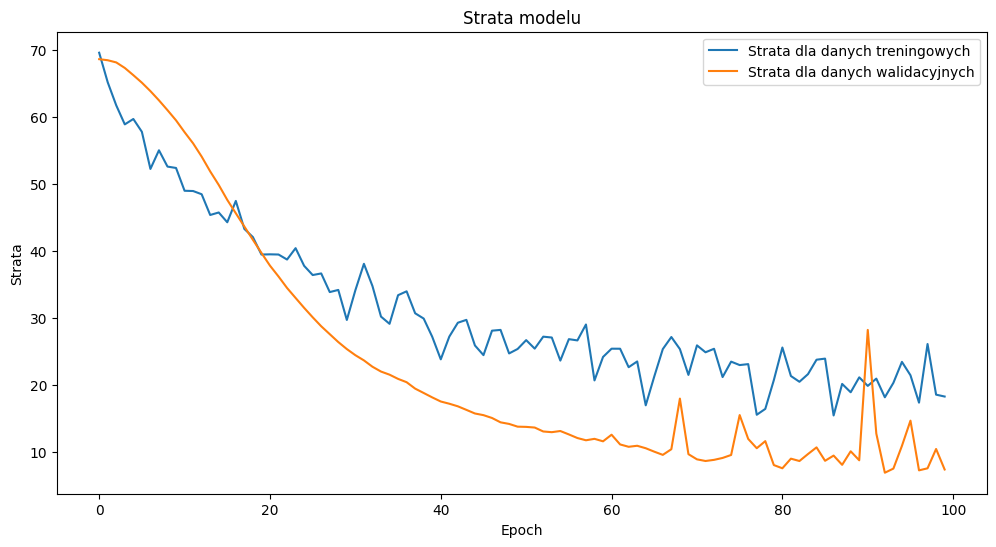

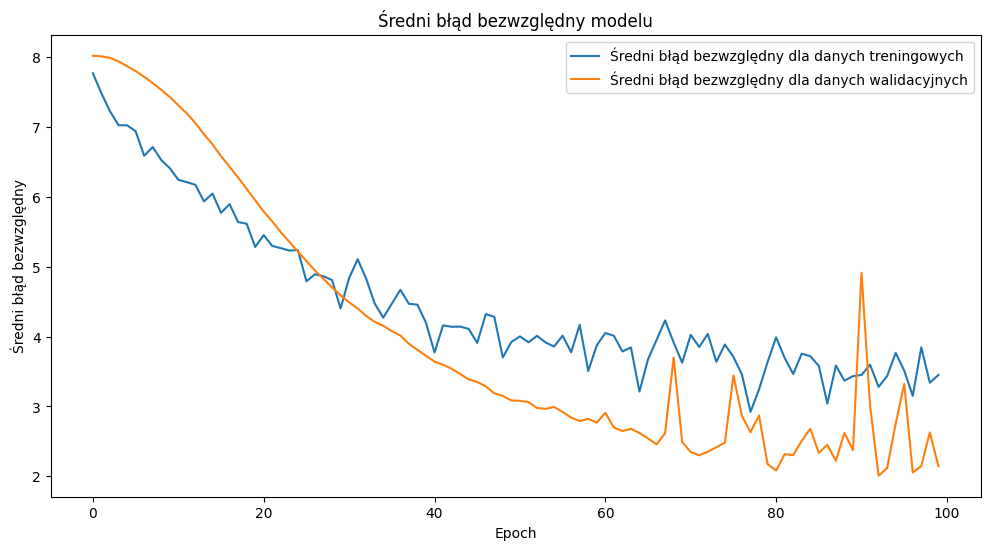

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pickle 
from keras.models import load_model
with open('updateTrainHistoryDict', "rb") as file_pi:
    history = pickle.load(file_pi)
model = load_model("update_model.h5")
model.load_weights('update_model.weights.h5')

import os
if not os.path.isdir("plots_training"):
    os.makedirs('plots_training')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Strata dla danych treningowych')
plt.plot(history['val_loss'], label='Strata dla danych walidacyjnych')
plt.title('Strata modelu')
plt.xlabel('Epoch')
plt.ylabel('Strata')
plt.legend(loc='upper right')
plt.savefig("plots_training/Strata dla danych treningowych")
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(12, 6))
plt.plot(history['mae'], label='Średni błąd bezwzględny dla danych treningowych')
plt.plot(history['val_mae'], label='Średni błąd bezwzględny dla danych walidacyjnych')
plt.title('Średni błąd bezwzględny modelu')
plt.xlabel('Epoch')
plt.ylabel('Średni błąd bezwzględny')
plt.legend(loc='upper right')
plt.savefig("plots_training/Średni błąd bezwzględny dla danych treningowych")
plt.show()

